In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import timm
import warnings
warnings.filterwarnings('ignore')

DATASET_ROOT = r"C:\Projects\Thesis-Fall-25-26--G-606-main"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (224, 224)
BATCH_SIZE = 8
LEARNING_RATE = 0.00003
EPOCHS = 30
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device.type == 'cuda':
    torch.cuda.empty_cache()

class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.RandomResizedCrop(IMG_SIZE[0], scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_train = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_train)
dataset_test = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_test)

indices = list(range(len(dataset_train)))
split = int(np.floor(0.2 * len(dataset_train)))
np.random.seed(SEED)
np.random.shuffle(indices)

train_indices = indices[split:]
test_indices = indices[:split]

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(train_indices))
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, sampler=SubsetRandomSampler(test_indices))

class CrossAttention(nn.Module):
    def __init__(self, dim):
        super(CrossAttention, self).__init__()
        self.attention = nn.MultiheadAttention(dim, num_heads=8, batch_first=True, dropout=0.1)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim * 4, dim)
        )
        
    def forward(self, x, context):
        attn_out, _ = self.attention(x, context, context)
        x = self.norm1(x + attn_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        return x

class HybridVGGSwin(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridVGGSwin, self).__init__()
        
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        for param in self.vgg16.features[:20].parameters():
            param.requires_grad = False
        self.vgg16.classifier = nn.Sequential(*list(self.vgg16.classifier.children())[:-3])
        self.vgg_proj = nn.Linear(4096, 768)
        
        self.swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
        for param in self.swin.layers[:2].parameters():
            param.requires_grad = False
        swin_dim = self.swin.head.in_features
        self.swin.head = nn.Identity()
        self.swin_proj = nn.Linear(swin_dim, 768)
        
        self.cross_attn_vgg = CrossAttention(768)
        self.cross_attn_swin = CrossAttention(768)
        
        self.classifier = nn.Sequential(
            nn.Linear(1536, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # VGG features
        vgg_feat = self.vgg16.features(x)
        vgg_feat = vgg_feat.view(vgg_feat.size(0), -1)  # (B, 25088)
        vgg_feat = self.vgg16.classifier(vgg_feat)  # (B, 4096)
        vgg_feat = self.vgg_proj(vgg_feat).unsqueeze(1)  # (B, 1, 768)
        
        # Swin features - shape is (B, H, W, C) from forward_features
        swin_feat = self.swin.forward_features(x)  # (B, 7, 7, 768)
        B, H, W, C = swin_feat.shape
        swin_feat = swin_feat.view(B, H*W, C)  # (B, 49, 768)
        swin_feat = self.swin_proj(swin_feat)  # (B, 49, 768)
        
        # Expand VGG features to match Swin sequence length for attention
        vgg_feat_expanded = vgg_feat.expand(-1, swin_feat.size(1), -1)  # (B, 49, 768)
        
        # Cross attention
        vgg_enhanced = self.cross_attn_vgg(vgg_feat_expanded, swin_feat)
        swin_enhanced = self.cross_attn_swin(swin_feat, vgg_feat_expanded)
        
        # Pool features
        vgg_pooled = vgg_enhanced.mean(dim=1)  # (B, 768)
        swin_pooled = swin_enhanced.mean(dim=1)  # (B, 768)
        
        # Combine and classify
        combined = torch.cat([vgg_pooled, swin_pooled], dim=1)  # (B, 1536)
        output = self.classifier(combined)
        
        return output

model = HybridVGGSwin(num_classes=2).to(device)

vgg_path = os.path.join(DATASET_ROOT, 'vgg16_best_model.pth')
swin_path = os.path.join(DATASET_ROOT, 'swintransformer_fold1_best.pth')

if os.path.exists(vgg_path):
    try:
        vgg_state = torch.load(vgg_path, map_location=device)
        model.vgg16.load_state_dict(vgg_state, strict=False)
        print("VGG16 weights loaded")
    except:
        pass

if os.path.exists(swin_path):
    try:
        swin_state = torch.load(swin_path, map_location=device)
        model.swin.load_state_dict(swin_state, strict=False)
        print("Swin weights loaded")
    except:
        pass

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.02)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
best_val_acc = 0.0

print("Training started...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_acc = 100 * correct / total
    epoch_train_loss = running_loss / len(train_loader)
    history['train_acc'].append(epoch_train_acc)
    history['train_loss'].append(epoch_train_loss)
    
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    epoch_val_acc = 100 * val_correct / val_total
    epoch_val_loss = val_loss / len(test_loader)
    history['val_acc'].append(epoch_val_acc)
    history['val_loss'].append(epoch_val_loss)
    
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train: {epoch_train_acc:.2f}% | Val: {epoch_val_acc:.2f}%")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(DATASET_ROOT, 'hybrid_vgg_swin_best.pth'))
        print(f"Best model saved: {best_val_acc:.2f}%")

print(f"Training complete. Best accuracy: {best_val_acc:.2f}%")

globals()['model'] = model
globals()['history'] = history
globals()['test_loader'] = test_loader
globals()['device'] = device
globals()['DATASET_ROOT'] = DATASET_ROOT
globals()['IMAGES_DIR'] = IMAGES_DIR

Device: cuda


VGG16 weights loaded
Swin weights loaded
Training started...
Epoch 1/30 | Train: 86.96% | Val: 99.33%
Best model saved: 99.33%
Epoch 2/30 | Train: 95.65% | Val: 96.64%
Epoch 3/30 | Train: 96.32% | Val: 100.00%
Best model saved: 100.00%
Epoch 4/30 | Train: 96.32% | Val: 95.97%
Epoch 5/30 | Train: 96.32% | Val: 96.64%
Epoch 6/30 | Train: 98.16% | Val: 100.00%
Epoch 7/30 | Train: 97.66% | Val: 100.00%
Epoch 8/30 | Train: 97.16% | Val: 100.00%
Epoch 9/30 | Train: 98.16% | Val: 100.00%
Epoch 10/30 | Train: 97.83% | Val: 100.00%
Epoch 11/30 | Train: 96.66% | Val: 98.66%
Epoch 12/30 | Train: 95.99% | Val: 100.00%
Epoch 13/30 | Train: 96.49% | Val: 100.00%
Epoch 14/30 | Train: 97.83% | Val: 97.99%
Epoch 15/30 | Train: 97.99% | Val: 100.00%
Epoch 16/30 | Train: 97.32% | Val: 97.99%
Epoch 17/30 | Train: 97.83% | Val: 100.00%
Epoch 18/30 | Train: 98.33% | Val: 97.99%
Epoch 19/30 | Train: 97.83% | Val: 100.00%
Epoch 20/30 | Train: 98.49% | Val: 99.33%
Epoch 21/30 | Train: 98.66% | Val: 100.00%
Epo

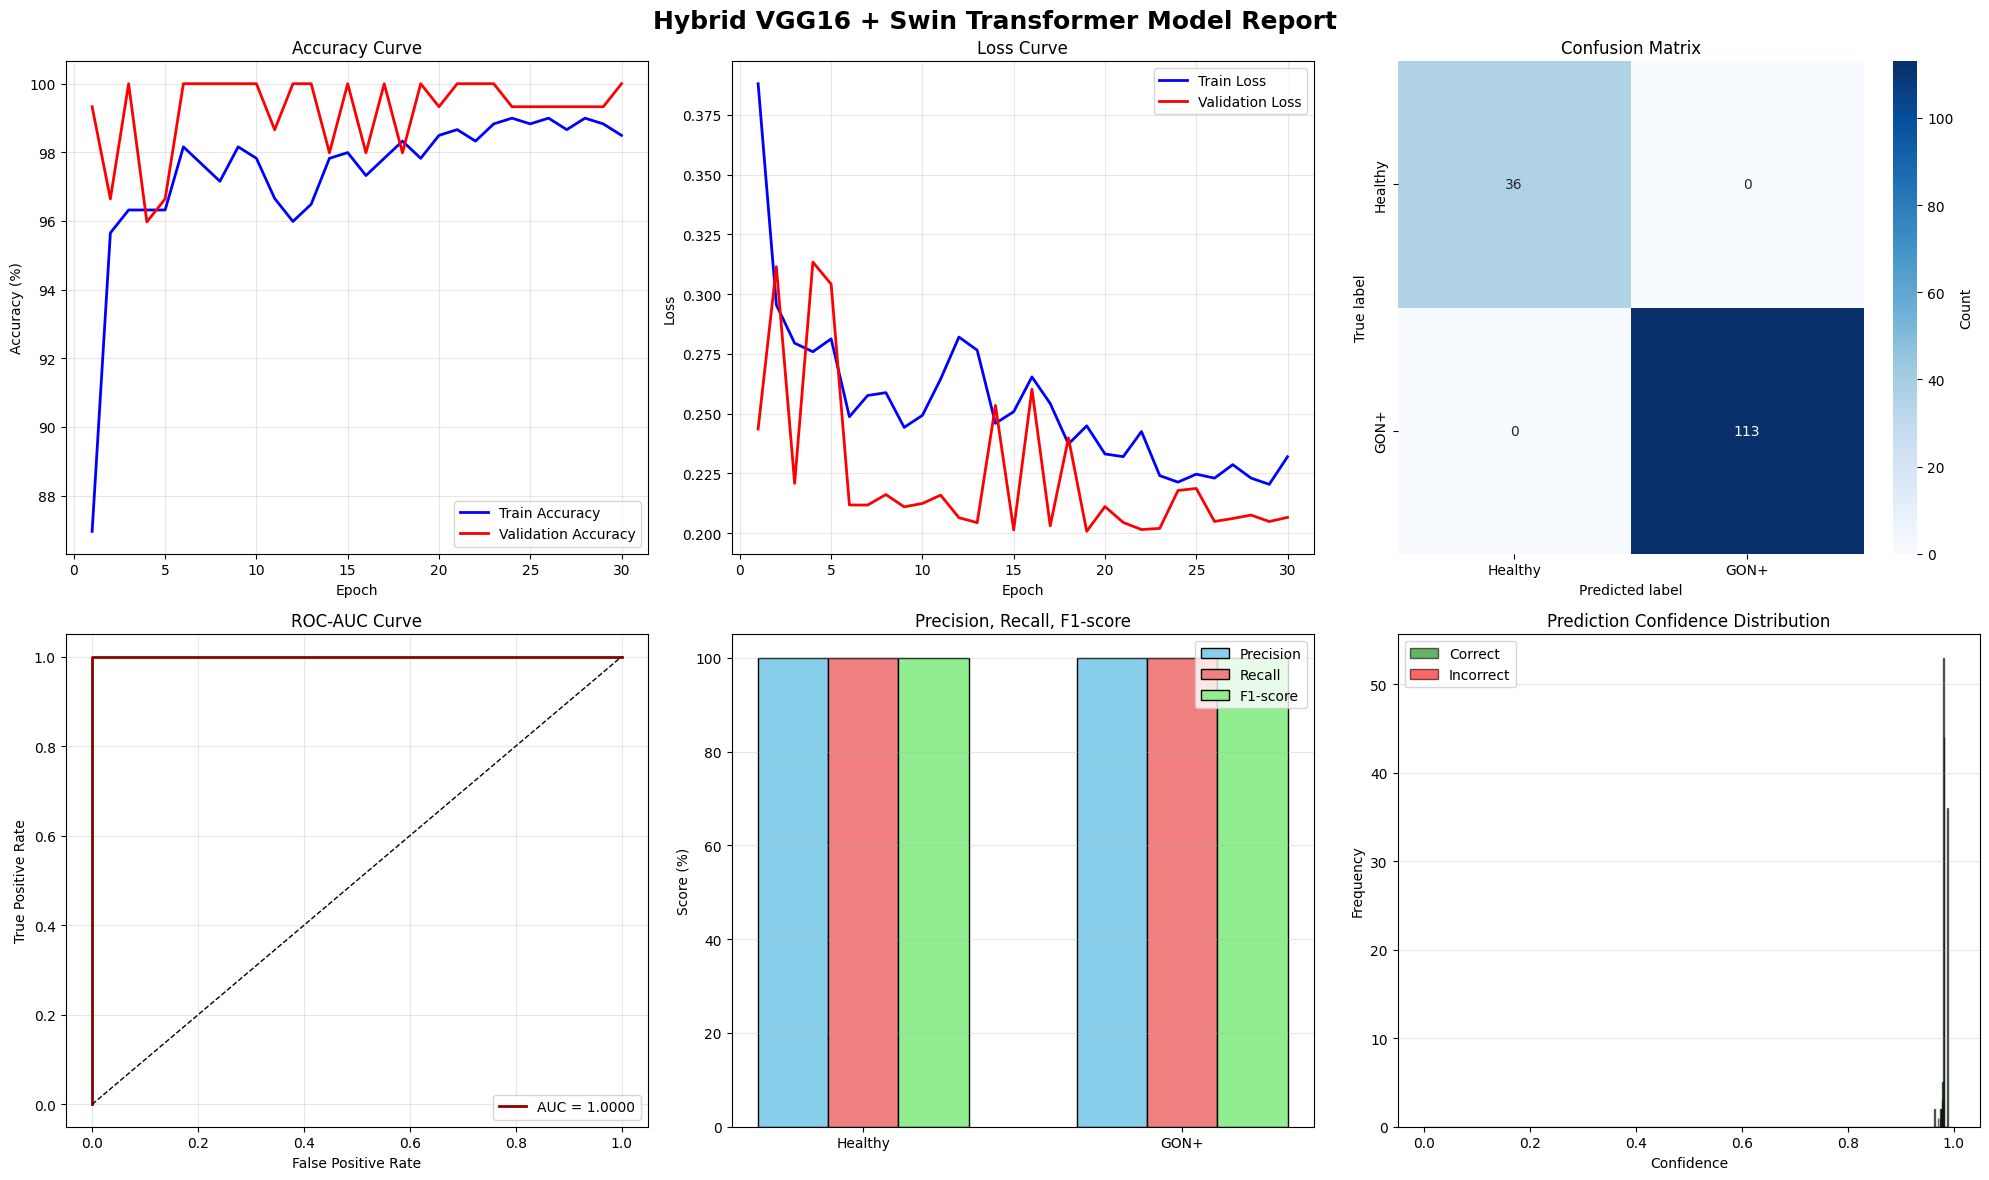


Classification Report:
              precision    recall  f1-score   support

     Healthy     1.0000    1.0000    1.0000        36
        GON+     1.0000    1.0000    1.0000       113

    accuracy                         1.0000       149
   macro avg     1.0000    1.0000    1.0000       149
weighted avg     1.0000    1.0000    1.0000       149


Accuracy: 100.00%
Sensitivity: 100.00%
Specificity: 100.00%
Precision GON+: 100.00%
AUC-ROC: 1.0000


In [2]:
# CELL 2: FULL HYBRID MODEL REPORT (LOSS, ACCURACY, CONFUSION MATRIX, ROC, METRICS)


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, roc_curve, auc
import numpy as np
import torch

model.load_state_dict(torch.load(os.path.join(DATASET_ROOT, 'hybrid_vgg_swin_best.pth')))
model.eval()

y_true = []
y_pred = []
y_probs = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())
    y_probs.extend(probs[:, 1].cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred) * 100
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
epochs_range = range(1, len(history['train_acc']) + 1)

fig = plt.figure(figsize=(20, 12))

# Accuracy Curve
ax1 = plt.subplot(2, 3, 1)
plt.plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
plt.plot(epochs_range, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(alpha=0.3)

# Loss Curve
ax2 = plt.subplot(2, 3, 2)
plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
plt.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(alpha=0.3)

# Confusion Matrix
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'GON+'],
            yticklabels=['Healthy', 'GON+'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# ROC Curve
ax4 = plt.subplot(2, 3, 4)
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkred', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.grid(alpha=0.3)

# Metrics By Class
ax5 = plt.subplot(2, 3, 5)
classes = ['Healthy', 'GON+']
x = np.arange(len(classes))
width = 0.22
plt.bar(x - width, precision * 100, width, label='Precision', color='skyblue', edgecolor='black')
plt.bar(x, recall * 100, width, label='Recall', color='lightcoral', edgecolor='black')
plt.bar(x + width, f1 * 100, width, label='F1-score', color='lightgreen', edgecolor='black')
plt.xticks(x, classes)
plt.ylabel('Score (%)')
plt.title('Precision, Recall, F1-score')
plt.legend()
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)

# Prediction Confidence Distribution
ax6 = plt.subplot(2, 3, 6)
correct_mask = np.array(y_true) == np.array(y_pred)
corr_probs = np.array([y_probs[i] if y_pred[i]==1 else 1-y_probs[i] for i in range(len(y_probs)) if correct_mask[i]])
incorr_probs = np.array([y_probs[i] if y_pred[i]==1 else 1-y_probs[i] for i in range(len(y_probs)) if not correct_mask[i]])
plt.hist(corr_probs, bins=20, alpha=0.6, label='Correct', color='green', edgecolor='black')
plt.hist(incorr_probs, bins=20, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.suptitle('Hybrid VGG16 + Swin Transformer Model Report', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'GON+'], digits=4))

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100
precision_gon = tp / (tp + fp) * 100

print(f"\nAccuracy: {acc:.2f}%")
print(f"Sensitivity: {sensitivity:.2f}%")
print(f"Specificity: {specificity:.2f}%")
print(f"Precision GON+: {precision_gon:.2f}%")
print(f"AUC-ROC: {roc_auc:.4f}")

  0%|          | 0/1500 [00:00<?, ?it/s]

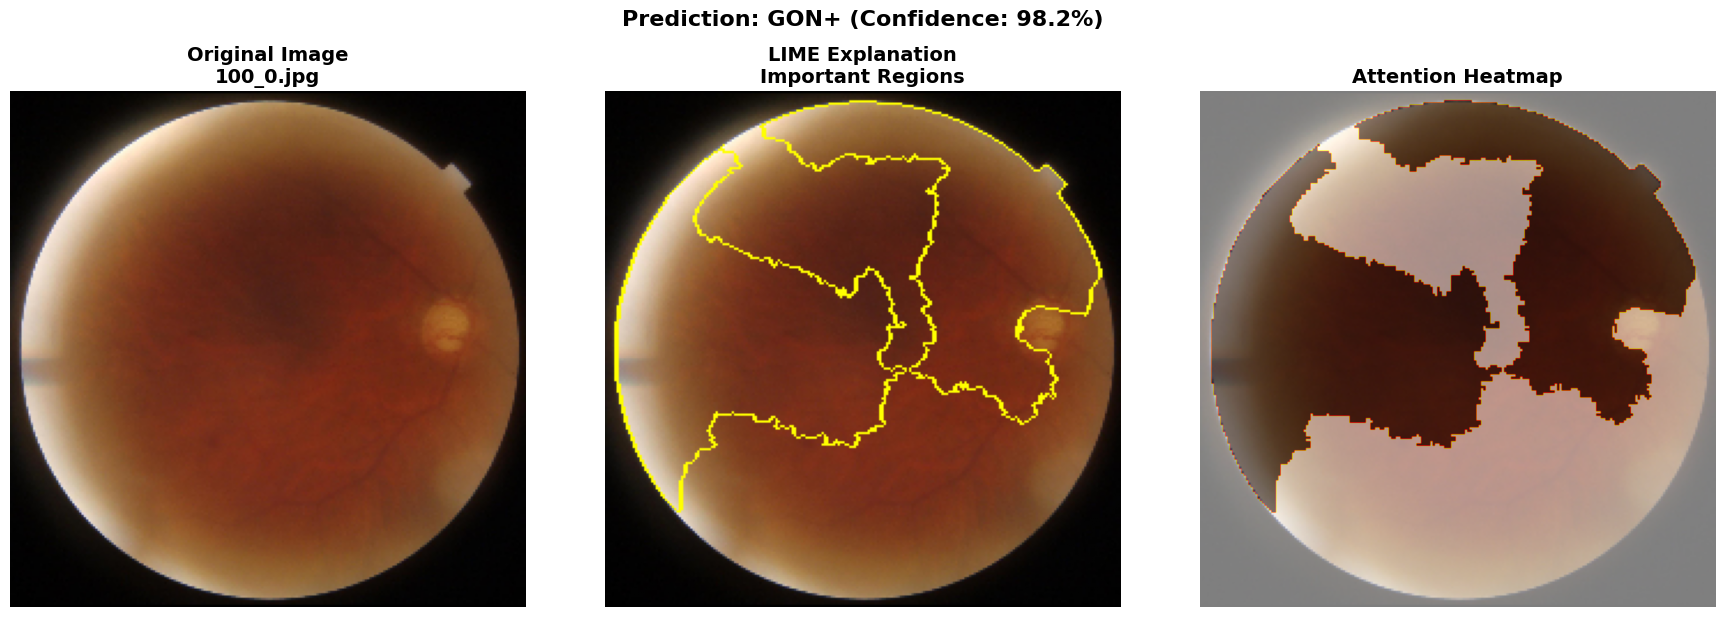

Prediction: GON+
Confidence: 98.16%
Healthy: 1.84%
GON+: 98.16%


In [3]:
# CELL 3: LIME EXPLAINABILITY

import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms

transform_lime = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_img_name = "100_0.jpg"
img_path = os.path.join(IMAGES_DIR, test_img_name)

img = cv2.imread(img_path)
if img is None:
    import glob
    all_images = glob.glob(os.path.join(IMAGES_DIR, "*.jpg"))
    img_path = all_images[0]
    test_img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))

def predict_fn(images):
    model.eval()
    images_torch = torch.stack([transform_lime(img) for img in images]).to(device)
    with torch.no_grad():
        outputs = model(images_torch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
    return probs

with torch.no_grad():
    img_tensor = transform_lime(img_resized).unsqueeze(0).to(device)
    output = model(img_tensor)
    probs = torch.softmax(output, dim=1).cpu().numpy()[0]
    pred_class = np.argmax(probs)
    pred_label = "GON+" if pred_class == 1 else "Healthy"
    confidence = probs[pred_class] * 100

explainer = LimeImageExplainer()
explanation = explainer.explain_instance(
    img_resized,
    predict_fn,
    labels=[0, 1],
    hide_color=0,
    num_samples=1500,
    batch_size=16
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_resized)
axes[0].set_title(f'Original Image\n{test_img_name}', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mark_boundaries(temp, mask))
axes[1].set_title('LIME Explanation\nImportant Regions', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(img_resized)
axes[2].imshow(mask, alpha=0.5, cmap='hot')
axes[2].set_title('Attention Heatmap', fontsize=14, fontweight='bold')
axes[2].axis('off')

fig.suptitle(f'Prediction: {pred_label} (Confidence: {confidence:.1f}%)', 
             fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

print(f"Prediction: {pred_label}")
print(f"Confidence: {confidence:.2f}%")
print(f"Healthy: {probs[0]*100:.2f}%")
print(f"GON+: {probs[1]*100:.2f}%")